## Transfer Learning For Computer Vision Tutorial

https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
plt.ion()  # interactive mode (oh!)

In [27]:
if os.system("ls hymenoptera_data") != 0:
    os.system("wget https://download.pytorch.org/tutorial/hymenoptera_data.zip")
    os.system("unzip hymenoptera_data.zip")
    os.system("rm hymenoptera_data.zip")

In [28]:
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.496], [0.229, 0.224, 0.225])  # wut?
    ]),
    "val": transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.496], [0.229, 0.224, 0.225])  # wut?
    ]),
}

In [42]:
data_dir = "hymenoptera_data"
image_datasets = {
    "train": datasets.ImageFolder(os.path.join(data_dir, "train"), data_transforms["train"]),
    "val": datasets.ImageFolder(os.path.join(data_dir, "val"), data_transforms["val"]),
}
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ["train", "val"]
}  # according to tutorial (but why?)
dataloaders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
    for x in ["train", "val"]
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### `datasets.ImageFolder`

Fetches (PIL.Image, label) from a directory containing classwise image directories

In [45]:
raw_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"))
sample = next(iter(raw_dataset))
print(sample)

(<PIL.Image.Image image mode=RGB size=768x512 at 0x7F7F72682940>, 0)


In [46]:
sample = next(iter(image_datasets["train"]))  # after transforms
sample[0].shape, sample[1]

(torch.Size([3, 224, 224]), 0)

In [47]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['ants', 'bees']

In [108]:
def show_image(image, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    image = image.numpy().transpose((1, 2, 0))  # from D, H, W to H, W, D
    mean = np.array([0.485, 0.456, 0.406])  # de-normalize
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    if title:
        ax.set_title(title)
    plt.pause(0.001)  # wut?

In [50]:
inputs, classes = next(iter(dataloaders["train"]))
grid = torchvision.utils.make_grid(inputs)
inputs.shape, grid.shape

(torch.Size([4, 3, 224, 224]), torch.Size([3, 228, 906]))

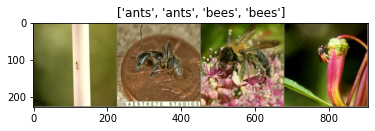

In [54]:
show_image(grid, title=[class_names[x] for x in classes])

### `torchvision.utils.make_grid`

Dis function useful af!

# Model

In [136]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
output_nodes = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, output_nodes)  # oh, just replace the layer..?
model_ft = model_ft.to(device)

In [60]:
outputs = model_ft(inputs.to(device))
outputs  # soft one-hot

tensor([[ 0.1117,  0.8075],
        [-0.0165,  0.3534],
        [-0.4608,  0.0554],
        [-0.8199, -0.7644]], device='cuda:0', grad_fn=<AddmmBackward>)

In [64]:
values, preds = outputs.max(axis=1)
values, preds

(tensor([ 0.8075,  0.3534,  0.0554, -0.7644], device='cuda:0',
        grad_fn=<MaxBackward0>),
 tensor([1, 1, 1, 1], device='cuda:0'))

# Training!

In [202]:
def train_model(model, criterion, optimizer, scheduler, epochs=25):
    """
    Train model and return best model and history
    
    Returns
        model: trained model,
        history: { acc: [], loss: [] }
    """
    since = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())  # srsly?
    best_acc = 0.0
    
    acc_history = []
    loss_history = []
    
    for epoch in range(epochs):
        print("Epoch {:02d}/{:02d}".format(epoch, epochs - 1))
        print("-" * 10)
        
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()  # set "mode" of model
            else:
                model.eval()
                
            running_loss = 0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:  # single epoch
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == "train"):  # conditional torch.no_grad()
                    # review: no_grad affects `node.requires_grad` which effects backprop via `backward()`
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)  # essentially, just another node in the network

                    if phase == "train":
                        loss.backward()  # backprop and obtain grads
                        optimizer.step()  # run optimizer step using grads (e.g., sgd would simply apply LR)

                # stats
                running_loss += loss.item() * inputs.size(0)  # oh, nice variable name: running
                running_corrects += torch.sum(preds == labels.data).item()  # .data: deprecated? function similar to detach()

            if phase == "train":
                scheduler.step()  # model, optimizer, scheduler seem to cross-reference each other (hmm)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print("{:>8s} Loss: {:.4f} Acc: {:.4f}".format(phase.title(), epoch_loss, epoch_acc))
            
            if phase == "val":
                acc_history.append(epoch_acc)
                loss_history.append(epoch_loss)
                
                # deep copy model if best
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_weights = copy.deepcopy(model.state_dict())

        # endfor each phase
    # endfor each epoch

    print()
    
    time_elapsed = time.time() - since
    print("Training complete in {}m {}s".format(
        time_elapsed // 60, time_elapsed % 60 // 1
    ))
    print("Best Val Acc: {:4f}".format(best_acc))
    
    history = {
        "acc": acc_history,
        "loss": loss_history,
    }
    
    model.load_state_dict(best_model_weights)  # load best weights (oh!)
    return model, history

In [178]:
def visualize_model(model):
    # Unlike tutorial, this will only display 2x2 using single batch
    was_training = model.training  # to put back after inference
    model.eval()
    images_so_far = 0
    fig = mpl.figure.Figure()
    axes = fig.subplots(2, 2).flatten()
    
    with torch.no_grad():
        inputs, labels = next(iter(dataloaders["val"]))
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        
        _, preds = outputs.max(axis=1)
        
        for i, (ax, pred) in enumerate(zip(axes, preds)):
            ax.axis("off")
            p, l = class_names[pred], class_names[labels[i]]
            show_image(inputs[i].cpu(), ax=ax, title="Pred {} ({})".format(p, l))
    return fig

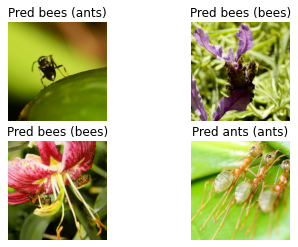

In [179]:
visualize_model(model_ft)

### Actually Start Training...

In [184]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)  # Note references to .parameters

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  # Note references to optimizer

In [185]:
# Reload model
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
output_nodes = len(class_names)
model_ft.fc = nn.Linear(num_ftrs, output_nodes)  # oh, just replace the layer..?
model_ft = model_ft.to(device)

In [186]:
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, epochs=25)

Epoch 00/24
----------
   Train Loss: 0.7257 Acc: 0.4877
     Val Loss: 0.7436 Acc: 0.4902
Epoch 01/24
----------
   Train Loss: 0.6874 Acc: 0.5492
     Val Loss: 0.7346 Acc: 0.4902
Epoch 02/24
----------
   Train Loss: 0.7440 Acc: 0.5164
     Val Loss: 0.7365 Acc: 0.4967
Epoch 03/24
----------
   Train Loss: 0.7199 Acc: 0.5246
     Val Loss: 0.7325 Acc: 0.4902
Epoch 04/24
----------
   Train Loss: 0.7249 Acc: 0.4959
     Val Loss: 0.7545 Acc: 0.4706
Epoch 05/24
----------
   Train Loss: 0.6846 Acc: 0.5656
     Val Loss: 0.7528 Acc: 0.4837
Epoch 06/24
----------
   Train Loss: 0.7230 Acc: 0.5328
     Val Loss: 0.7511 Acc: 0.4575
Epoch 07/24
----------
   Train Loss: 0.7098 Acc: 0.5123
     Val Loss: 0.7484 Acc: 0.4575
Epoch 08/24
----------
   Train Loss: 0.7230 Acc: 0.5369
     Val Loss: 0.7468 Acc: 0.5033
Epoch 09/24
----------
   Train Loss: 0.6814 Acc: 0.5246
     Val Loss: 0.7494 Acc: 0.4771
Epoch 10/24
----------
   Train Loss: 0.7073 Acc: 0.5082
     Val Loss: 0.7261 Acc: 0.4902

<AxesSubplot:>

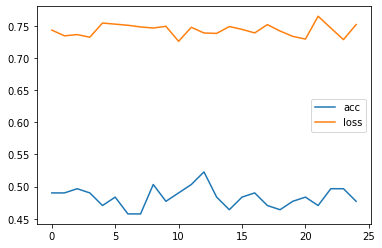

In [187]:
pd.DataFrame(history).plot()

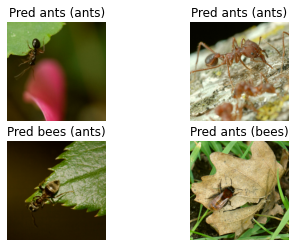

In [188]:
visualize_model(model_ft)

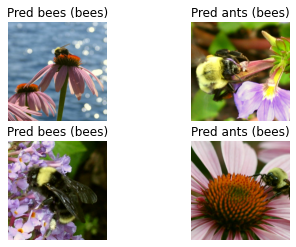

In [189]:
visualize_model(model_ft)

In [206]:
model_conv = models.resnet18(pretrained=True)
n = 0
for param in model_conv.parameters():  # parameters(): weight matrices (layers)
    param.requires_grad = False
    n += 1
print(n)

62


In [207]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [208]:
model_conv, history = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, epochs=25)

Epoch 00/24
----------
   Train Loss: 0.5857 Acc: 0.6885
     Val Loss: 0.2157 Acc: 0.9412
Epoch 01/24
----------
   Train Loss: 0.5884 Acc: 0.7336
     Val Loss: 0.1799 Acc: 0.9477
Epoch 02/24
----------
   Train Loss: 0.4809 Acc: 0.7869
     Val Loss: 0.2279 Acc: 0.9281
Epoch 03/24
----------
   Train Loss: 0.6625 Acc: 0.7336
     Val Loss: 0.1909 Acc: 0.9477
Epoch 04/24
----------
   Train Loss: 0.3881 Acc: 0.8197
     Val Loss: 0.2587 Acc: 0.9216
Epoch 05/24
----------
   Train Loss: 0.5240 Acc: 0.7787
     Val Loss: 0.2116 Acc: 0.9477
Epoch 06/24
----------
   Train Loss: 0.5321 Acc: 0.7910
     Val Loss: 0.5096 Acc: 0.8235
Epoch 07/24
----------
   Train Loss: 0.4765 Acc: 0.8197
     Val Loss: 0.1879 Acc: 0.9477
Epoch 08/24
----------
   Train Loss: 0.2999 Acc: 0.8730
     Val Loss: 0.2074 Acc: 0.9477
Epoch 09/24
----------
   Train Loss: 0.3068 Acc: 0.8525
     Val Loss: 0.1959 Acc: 0.9477
Epoch 10/24
----------
   Train Loss: 0.2672 Acc: 0.8852
     Val Loss: 0.1926 Acc: 0.9477

<AxesSubplot:>

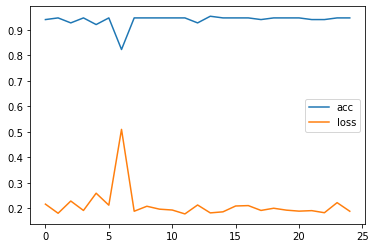

In [209]:
pd.DataFrame(history).plot()

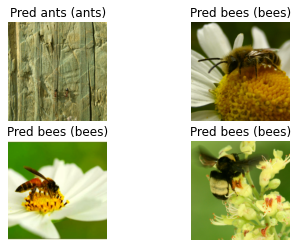

In [210]:
visualize_model(model_conv)

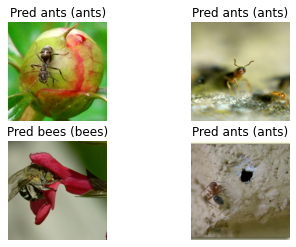

In [212]:
visualize_model(model_conv)

### Looks promising

:)